In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from keras import backend as K
import keras
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.regularizers import l2

import load_images

In [2]:
X_train, Y_train, X_validation, Y_validation, X_test, Y_test = load_images.getDataset()

In [8]:
from ResNet import ResNet18
model = ResNet18(7,(48,48,1))
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 24, 24, 24)   216         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 24, 24, 24)  96          ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 24, 24, 24)   0           ['batch_normalization_20[0

                                                                  'batch_normalization_29[0][0]'] 
                                                                                                  
 activation_25 (Activation)     (None, 6, 6, 48)     0           ['add_11[0][0]']                 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 3, 3, 96)     41472       ['activation_25[0][0]']          
                                                                                                  
 batch_normalization_31 (BatchN  (None, 3, 3, 96)    384         ['conv2d_31[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_26 (Activation)     (None, 3, 3, 96)     0           ['batch_normalization_31[0][0]'] 
          

 oling2D)                                                                                         
                                                                                                  
 flatten_1 (Flatten)            (None, 192)          0           ['average_pooling2d_1[0][0]']    
                                                                                                  
 dense_1 (Dense)                (None, 7)            1351        ['flatten_1[0][0]']              
                                                                                                  
Total params: 1,577,791
Trainable params: 1,574,191
Non-trainable params: 3,600
__________________________________________________________________________________________________


In [9]:
from keras.preprocessing.image import ImageDataGenerator
from random_eraser import get_random_eraser # random erase portion of the image
# datagen = ImageDataGenerator(
#         rotation_range=30,
#         zoom_range=0.3,
#         width_shift_range=0.3,
#         height_shift_range=0.3,
#         horizontal_flip = True,
#         shear_range = 0.3,
#         preprocessing_function=get_random_eraser(v_l=0, v_h=1,pixel_level= True),
#         fill_mode="nearest")
datagen = ImageDataGenerator(
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip = True,
        preprocessing_function=get_random_eraser(v_l=0, v_h=1,pixel_level= True),
        fill_mode="nearest")

In [10]:
BS = 128
seed = 1234
train_generator = datagen.flow(X_train, Y_train, batch_size=BS,shuffle = True,seed = seed)

In [12]:
# from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
# lr_decayed_fn = CosineDecayRestarts(
#     initial_learning_rate = 1e-2,
#     first_decay_steps = 50,
#     t_mul=2.0,
#     m_mul=1.0,
#     alpha=1e-3,
#     name=None
# )
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    optimizer= Adam(learning_rate= 1e-2), 
    metrics=['accuracy']
)
# earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(filepath = 'models/Resnet18', 
        save_freq = 'epoch' ,
        save_best_only = True,
        save_weights_only=True,
        monitor = 'val_loss',
        mode ='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=1, mode='min',min_lr= 1e-7)
# from cosine_annealing import CosineAnnealingScheduler
# cos_decay = CosineAnnealingScheduler(T_max=200, eta_max=1e-2, eta_min=1e-5)

callbacks = [mcp_save,reduce_lr_loss]

In [13]:
history = model.fit(x =train_generator, steps_per_epoch=X_train.shape[0] // BS,
                    epochs=400,verbose=1, validation_data=(X_validation, Y_validation),callbacks = callbacks,shuffle = True)

Epoch 1/400
168/168 [==============================] - 41s 234ms/step - loss: 2.3230 - accuracy: 0.2289 - val_loss: 2.0893 - val_accuracy: 0.2512 - lr: 0.0100
Epoch 2/400
168/168 [==============================] - 38s 225ms/step - loss: 1.9790 - accuracy: 0.2438 - val_loss: 2.0417 - val_accuracy: 0.1718 - lr: 0.0100
Epoch 3/400
168/168 [==============================] - 38s 225ms/step - loss: 1.8689 - accuracy: 0.2553 - val_loss: 2.3258 - val_accuracy: 0.1315 - lr: 0.0100
Epoch 4/400
168/168 [==============================] - 38s 227ms/step - loss: 1.8310 - accuracy: 0.2650 - val_loss: 1.9665 - val_accuracy: 0.2575 - lr: 0.0100
Epoch 5/400
168/168 [==============================] - 39s 229ms/step - loss: 1.8128 - accuracy: 0.2808 - val_loss: 1.8488 - val_accuracy: 0.2870 - lr: 0.0100
Epoch 6/400
168/168 [==============================] - 38s 228ms/step - loss: 1.7730 - accuracy: 0.3087 - val_loss: 1.7522 - val_accuracy: 0.3253 - lr: 0.0100
Epoch 7/400
168/168 [=========================

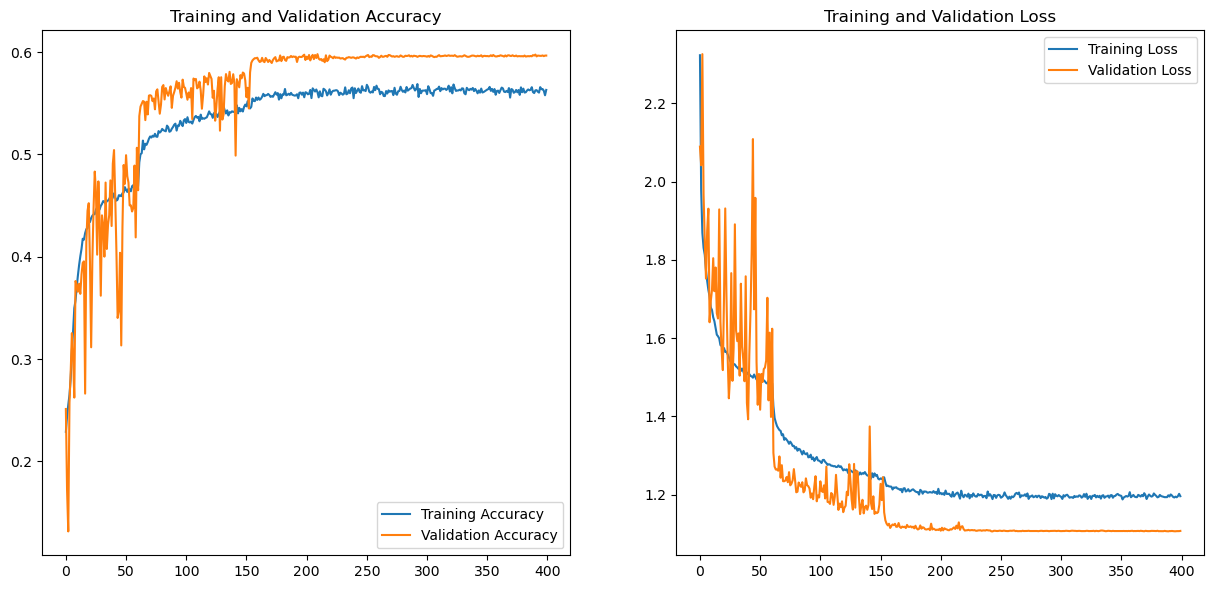

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(400)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# best model prediction on test data
model.load_weights('models/Resnet18')
prediction = model.predict(X_test) # for each datapoint, gives a (1,7) vector contains probabilities

ValueError: in user code:

    File "C:\Miniconda\envs\cs179\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Miniconda\envs\cs179\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Miniconda\envs\cs179\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Miniconda\envs\cs179\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Miniconda\envs\cs179\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Miniconda\envs\cs179\lib\site-packages\keras\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'ResNet18' (type Functional).
    
    Input 0 of layer "conv2d_40" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 48, 48, 3)
    
    Call arguments received by layer 'ResNet18' (type Functional):
      • inputs=tf.Tensor(shape=(None, 48, 48, 3), dtype=float32)
      • training=False
      • mask=None


In [13]:
Y_prediction = np.argmax(prediction,axis = 1) # get the index(label) of highest probability for each testing datapoint
prediction_accuracy = np.mean(Y_prediction==Y_test)
print("The accuracy on test data is: ", prediction_accuracy)

The accuracy on test data is:  0.5440234048481472


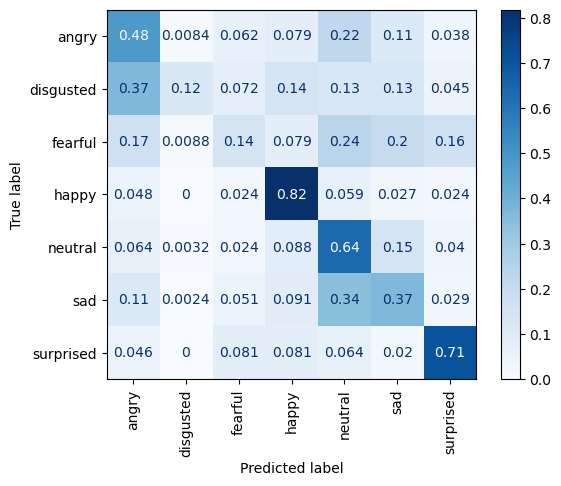

In [14]:
from sklearn.metrics import confusion_matrix, roc_auc_score,ConfusionMatrixDisplay
# confusion matrix
classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
cm = confusion_matrix(Y_test, Y_prediction, normalize= 'true')
disp = ConfusionMatrixDisplay(cm, display_labels = classes)
disp.plot(xticks_rotation = 'vertical',cmap=plt.cm.Blues)

In [15]:
# best model prediction on test data
model.load_weights('models/Resnet18')
prediction = model.predict(X_test) # for each datapoint, gives a (1,7) vector contains probabilities

ValueError: in user code:

    File "C:\Miniconda\envs\cs179\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Miniconda\envs\cs179\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Miniconda\envs\cs179\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Miniconda\envs\cs179\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Miniconda\envs\cs179\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Miniconda\envs\cs179\lib\site-packages\keras\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'ResNet18' (type Functional).
    
    Input 0 of layer "conv2d_20" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 48, 48, 3)
    
    Call arguments received by layer 'ResNet18' (type Functional):
      • inputs=tf.Tensor(shape=(None, 48, 48, 3), dtype=float32)
      • training=False
      • mask=None


In [6]:
Y_prediction = np.argmax(prediction,axis = 1) # get the index(label) of highest probability for each testing datapoint
prediction_accuracy = np.mean(Y_prediction==Y_test)
print("The accuracy on test data is: ", prediction_accuracy)

The accuracy on test data is:  0.6131234327110616


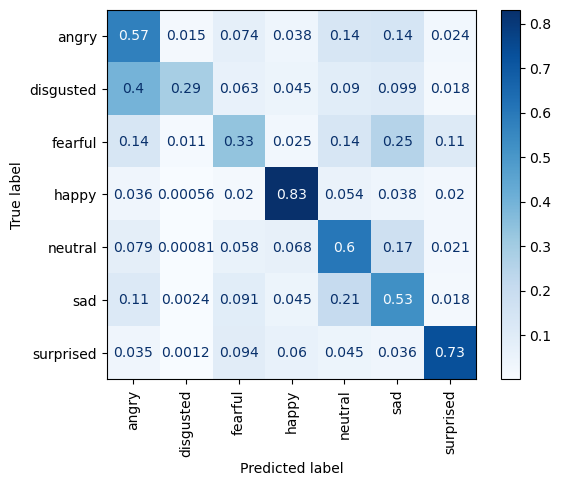

In [7]:
from sklearn.metrics import confusion_matrix, roc_auc_score,ConfusionMatrixDisplay
# confusion matrix
classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
cm = confusion_matrix(Y_test, Y_prediction, normalize= 'true')
disp = ConfusionMatrixDisplay(cm, display_labels = classes)
disp.plot(xticks_rotation = 'vertical',cmap=plt.cm.Blues)

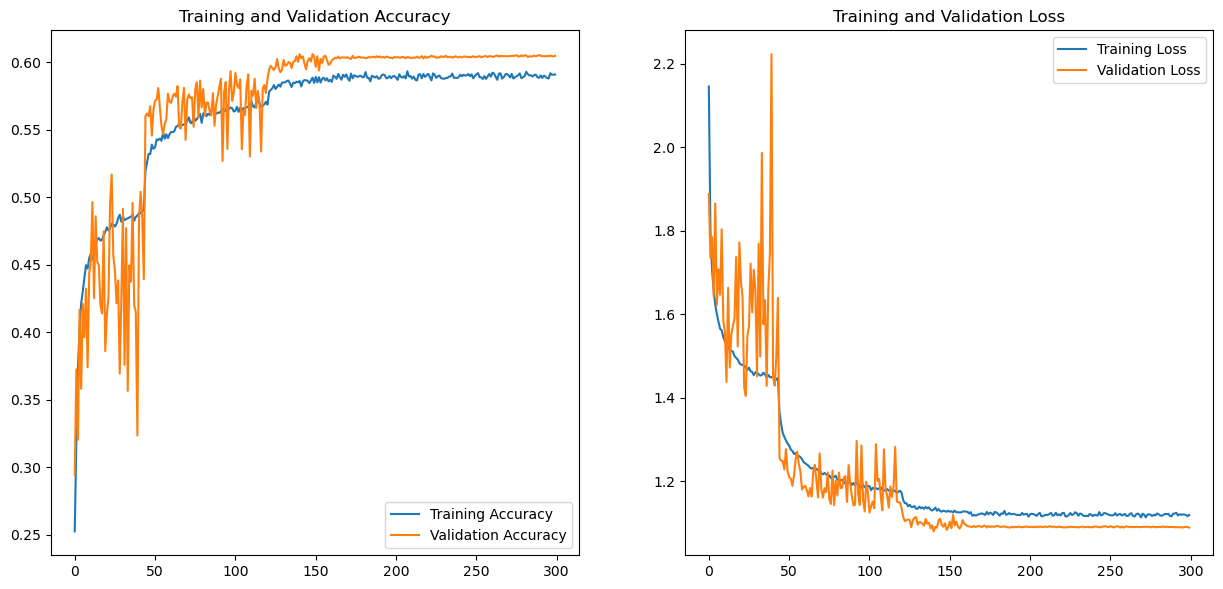

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(188)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
# import visualkeras
# visualkeras.layered_view(model, legend =True).show()